# Mobile phone price range classification

An analysis by [Vallian Sayoga](https://www.linkedin.com/in/vallian97/)

On data set by [Abhishek Sharma](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification)

This data set might contain phones from 1990-2017 and have not been updated since

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
sns.set_theme(font="JetBrains Mono")

# Data loading

In [2]:
df = pd.read_csv("phone_train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.shape

(2000, 21)

All of them are numerical data types

In [4]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

No NaN value so we can directly go into algorithm based features selection

In [5]:
df.price_range.unique()

array([1, 2, 3, 0], dtype=int64)

There are 4 price range

In [6]:
df.price_range.value_counts().sort_index()

0    500
1    500
2    500
3    500
Name: price_range, dtype: int64

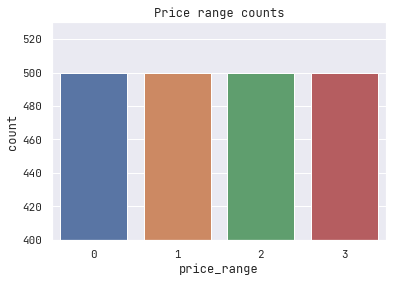

In [7]:
ax = sns.countplot(x=df.price_range)
ax.set(title="Price range counts", ylim=(400,530))
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [9]:
df.pc.unique()

array([ 2,  6,  9, 14,  7, 10,  0, 15,  1, 18, 17, 11, 16,  4, 20, 13,  3,
       19,  8,  5, 12], dtype=int64)

# EDA
Based on [USA Today](https://www.usatoday.com/story/tech/columnist/komando/2013/12/13/smartphone-battery-processing-display-camera/3921399/) article on 10 must have features on a smartphone, these are the most important features:
1. Touch screen (touch_screen) --> Not negotiable for a smarthpone
1. Battery (battery_power)
1. Processing power (clock_speed, n_cores)
1. Display clarity
1. Camera
1. NFC / Near Field Communication
1. Multiple display
1. Storage (int_memory, and let's include RAM too)
1. Infrared control
1. Fingerprint sensor
1. Wireless charging

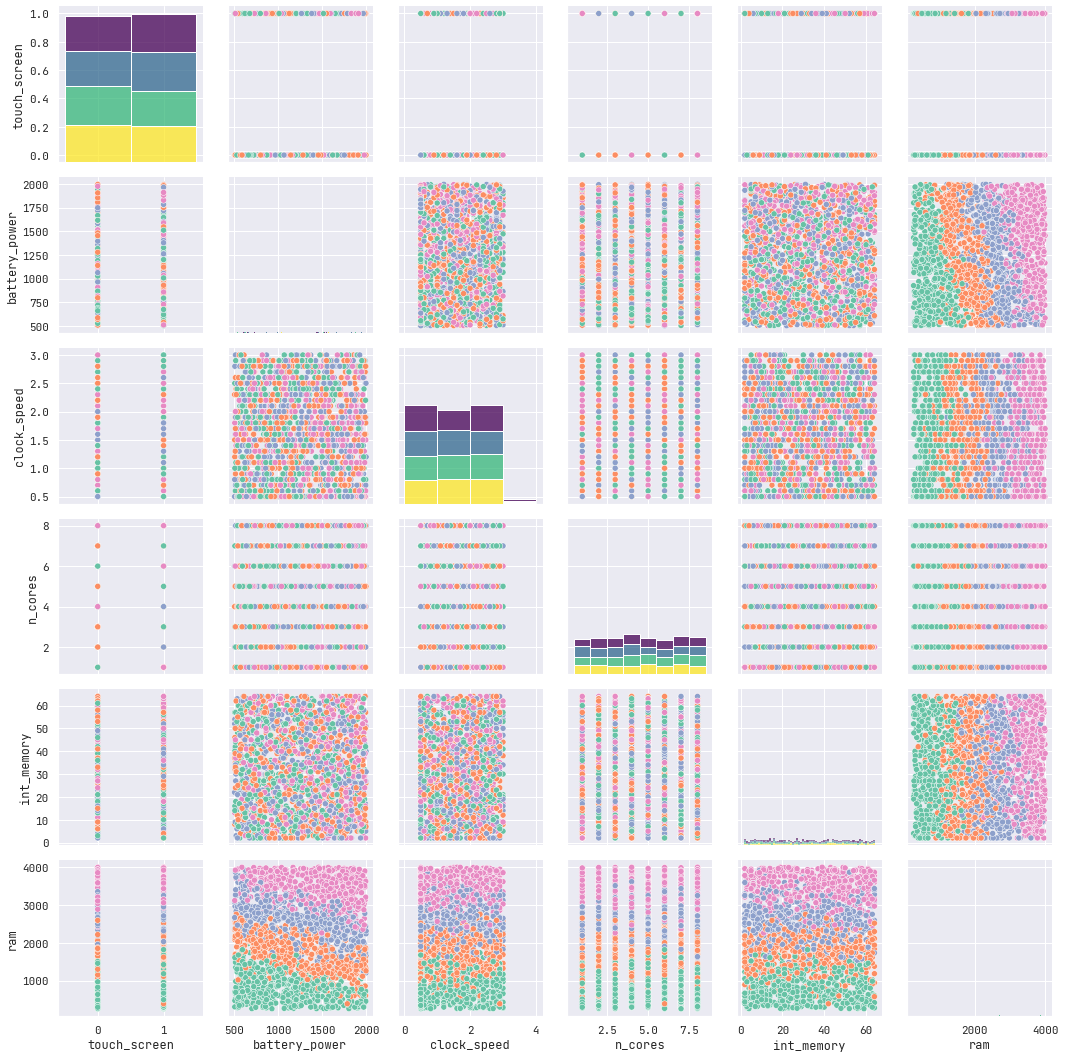

In [10]:
# Let's see the interactions between the features and categorized by price_range
data = df[[
    'touch_screen',
    'battery_power',
    'clock_speed',
    'n_cores',
    'int_memory',
    'ram',
    'price_range'
]]
# multiple : {"layer", "dodge", "stack", "fill"}
g = sns.PairGrid(data, hue='price_range')
g.map_offdiag(sns.scatterplot, palette='Set2')
g.map_diag(sns.histplot, palette='viridis', multiple='stack', discrete=True)
plt.show()

There are clear price range segmentations on:
1. battery_power vs ram
1. clock_speed vs ram
1. int_memory vs ram

# Feature engineering

In [11]:
# Display area is px_width * px_height
df['display_area'] = df.px_width * df.px_height
df['display_area'].head()

0      15120
1    1799140
2    2167308
3    2171776
4    1464096
Name: display_area, dtype: int64

# Feature Selection

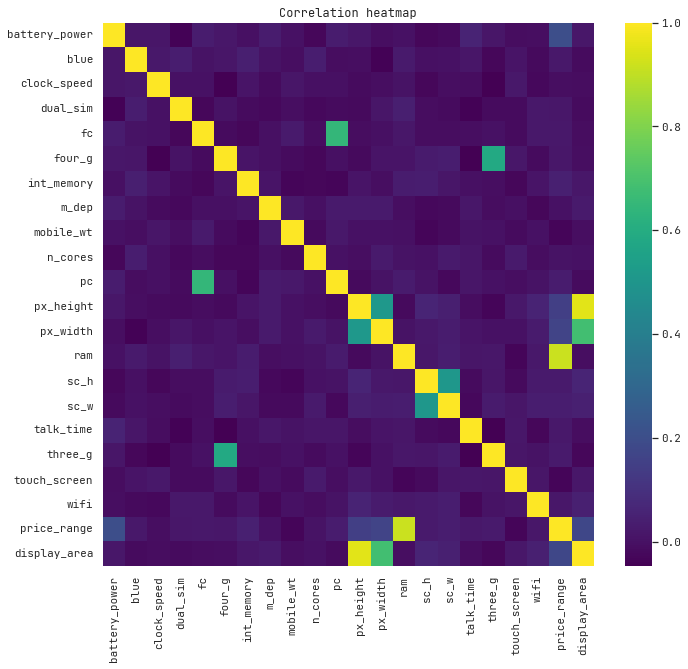

In [12]:
plt.figure(figsize=(11,10))
ax = sns.heatmap(df.corr(), cmap='viridis')
ax.set(title='Correlation heatmap',)
plt.show()

Strong colinearity on display_area vs px_height/px_width

But for now let the algorithms choose the best features

In [13]:
X = df.drop("price_range", axis=1)
y = df.price_range

# Modelling

Natively supported multiclass algorithms:
* Logistic Regression
* KNN
* Decision Tree
* Random Forest

**Steps**
1. Check whole training data set with pipeline & cross_val_score
2. Grid Search best parameters of the best scoring feature selection algorithm
2. Classification report & confusion matrix on split data set
3. Final predictions using testing data set

In [14]:
# Import prerocessing, model selection, pipeline, metrics, and 2 multi class classifier
import re
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Feature selection algorithm
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [15]:
def generate_cr_cm(estimator, xvalidation, yvalidation):
    """
    Function to generate classification report & confusion matrix
    
    Only printing the results
    """
    yhat = estimator.predict(xvalidation)
    # Classification report
    cr = classification_report(yvalidation, yhat)
    print(cr)
    print("")
    
    # Confusion matrix
    confusion_matrix = ConfusionMatrixDisplay.from_predictions(yvalidation, yhat)
    plt.title(f"{estimator.best_estimator_.steps[2][0]} confusion matrix")
    plt.grid(False)
    plt.show()

In [16]:
def generate_score(estimator, X, y):
    """
    Calculating cross validation scores for 2 feature selection algorithms
    
    return the best scoring pipe object
    """
    # Variance
    pipe1 = make_pipeline(var_thresh, scaler, estimator)
    pipe2 = make_pipeline(kbest, scaler, estimator)
    
    score1 = cross_val_score(pipe1, X, y, cv=shuffle,).mean()
    print("Variance score:", score1)
    score2 = cross_val_score(pipe2, X, y, cv=shuffle,).mean()
    print("Kbest score:", score2)
    print("--------------------------------------------------")
    
    if score1 > score2:
        print("Returning variance based pipeline")
        return pipe1
    print("Returning kbest based pipeline")
    return pipe2

In [17]:
def generate_param_and_report(pipe, param_grid, xtrain, xval, ytrain, yval):
    """
    function to generate best params, selected geatures,
    classification report & confusion matrix
    
    return Grid object & feature names
    """
    grid = GridSearchCV(pipe, params,)
    grid.fit(xtrain, ytrain)
    print("Best score:", round(grid.best_score_, 4))
    print("Best params:")
    pprint(grid.best_params_)
    print("---------------------------------------------")
    features = grid.best_estimator_.steps[0][1].get_feature_names_out()
    print("Selected features")
    pprint(features)
    print("---------------------------------------------")
    generate_cr_cm(grid, xval, yval)
    return grid, features

In [18]:
# Supporting objects initiation
var_thresh = VarianceThreshold(1.0)
kbest = SelectKBest(f_classif, k=10)
scaler = StandardScaler()
shuffle = ShuffleSplit(test_size=0.3, random_state=0)

In [19]:
# Splitting
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, multi_class='multinomial')
best_log_pipe = generate_score(clf, X, y)

Variance score: 0.9651666666666667
Kbest score: 0.9645000000000001
--------------------------------------------------
Returning variance based pipeline


Best score: 0.97
Best params:
{'logisticregression__C': 10,
 'logisticregression__tol': 0.001,
 'variancethreshold__threshold': 0.1}
---------------------------------------------
Selected features
array(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'display_area'], dtype=object)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.93      0.95      0.94       150
           2       0.94      0.96      0.95       150
           3       0.99      0.96      0.98       150

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600




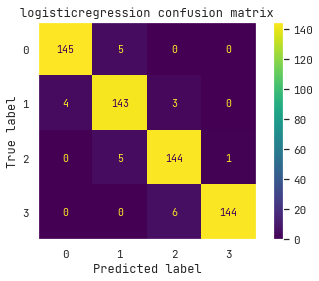

In [21]:
params = dict(
    variancethreshold__threshold=[0,0.01,0.1,0.2],
    logisticregression__C=[0.1,1,10],
    logisticregression__tol=[10e-4,10e-3,10e-2]
)
best_log_grid, _ = generate_param_and_report(best_log_pipe, params, X_train, X_val, y_train, y_val)

## K Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
best_knn_pipe = generate_score(clf, X, y)

Variance score: 0.5943333333333334
Kbest score: 0.6718333333333334
--------------------------------------------------
Returning kbest based pipeline


Best score: 0.7621
Best params:
{'kneighborsclassifier__n_neighbors': 17,
 'kneighborsclassifier__weights': 'distance',
 'selectkbest__k': 9}
---------------------------------------------
Selected features
array(['battery_power', 'int_memory', 'mobile_wt', 'n_cores', 'px_height',
       'px_width', 'ram', 'sc_h', 'display_area'], dtype=object)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       150
           1       0.62      0.62      0.62       150
           2       0.62      0.67      0.64       150
           3       0.89      0.79      0.84       150

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600




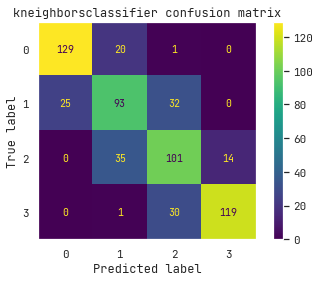

In [23]:
params = dict(
    selectkbest__k=[9,10,11,12],
    kneighborsclassifier__n_neighbors=list(range(2,21)),
    kneighborsclassifier__weights=['uniform', 'distance']
)
best_knn_grid, _ = generate_param_and_report(best_knn_pipe, params, X_train, X_val, y_train, y_val)

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
best_dtree_pipe = generate_score(clf, X, y)

Variance score: 0.8428333333333333
Kbest score: 0.8531666666666666
--------------------------------------------------
Returning kbest based pipeline


Best score: 0.8507
Best params:
{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 7,
 'decisiontreeclassifier__max_features': None,
 'selectkbest__k': 12}
---------------------------------------------
Selected features
array(['battery_power', 'four_g', 'int_memory', 'm_dep', 'mobile_wt',
       'n_cores', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
       'display_area'], dtype=object)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       150
           1       0.83      0.79      0.81       150
           2       0.77      0.81      0.79       150
           3       0.89      0.87      0.88       150

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.85       600
weighted avg       0.85      0.84      0.85       600




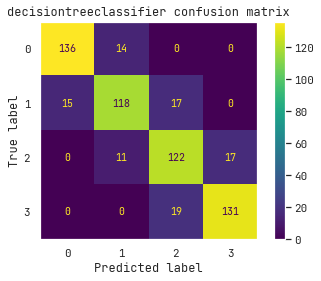

In [25]:
params = dict(
    selectkbest__k=[9,10,11,12],
    decisiontreeclassifier__criterion=['gini','entropy','log_loss'],
    decisiontreeclassifier__max_features=['sqrt','log2',None],
    decisiontreeclassifier__max_depth=[None,1,2,3,4,5,6,7,8]
)
best_dtree_grid, _ = generate_param_and_report(best_dtree_pipe, params, X_train, X_val, y_train, y_val)

# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
best_rf_pipe = generate_score(clf, X, y)

Variance score: 0.8933333333333333
Kbest score: 0.9036666666666667
--------------------------------------------------
Returning kbest based pipeline


Best score: 0.905
Best params:
{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': None,
 'selectkbest__k': 9}
---------------------------------------------
Selected features
array(['battery_power', 'int_memory', 'mobile_wt', 'n_cores', 'px_height',
       'px_width', 'ram', 'sc_h', 'display_area'], dtype=object)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.89      0.92      0.90       150
           2       0.83      0.85      0.84       150
           3       0.95      0.86      0.90       150

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.90       600
weighted avg       0.91      0.91      0.90       600




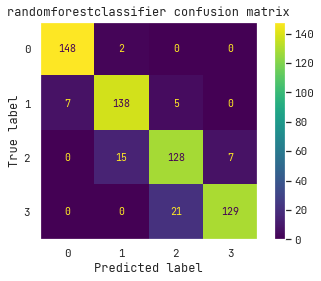

In [27]:
params = dict(
    selectkbest__k=[9,10,11,12],
    randomforestclassifier__criterion=['gini','entropy','log_loss'],
    randomforestclassifier__max_features=['sqrt','log2',None],
    randomforestclassifier__max_depth=[None,8]
)
best_rf_grid, _ = generate_param_and_report(best_rf_pipe, params, X_train, X_val, y_train, y_val)

# Final predictions using test set with Logistic Regression & Random Forest
Now let's predict the test data set

**Note that the test does not have `price_range` column**

So we can only predict without knowing the true labels

In [28]:
df_test = pd.read_csv("phone_test.csv")
df_test.drop('id', axis=1, inplace=True)
df_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [29]:
# Creating the display area
df_test['display_area'] = df_test.px_height * df_test.px_width

In [30]:
best_log_grid.best_params_

{'logisticregression__C': 10,
 'logisticregression__tol': 0.001,
 'variancethreshold__threshold': 0.1}

In [31]:
best_rf_grid.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': None,
 'selectkbest__k': 9}

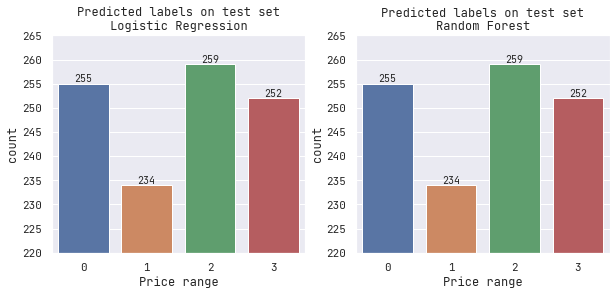

In [32]:
# Logistic Regression
best_log = make_pipeline(VarianceThreshold(0.1), StandardScaler(), LogisticRegression(random_state=0, C=10, tol=0.001))
best_log.fit(X_train, y_train)
yhat_log_test = pd.Series(best_log.predict(df_test))

# Random forest
best_rf = make_pipeline(SelectKBest(f_classif, k=9), StandardScaler(), RandomForestClassifier(random_state=0, criterion='entropy',))
best_rf.fit(X_train, y_train)
yhat_rf_test = pd.Series(best_log.predict(df_test))

fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ax, model, pred in zip(axs.flatten(), ['Logistic Regression', 'Random Forest'],
                          [yhat_log_test, yhat_rf_test]):
    f = sns.countplot(x=pred, ax=ax)
    f.set(ylim=(220,265), title=f'''Predicted labels on test set
{model}''', xlabel='Price range')
    for i, v in pred.value_counts().sort_index().iteritems():
        ax.text(i, v+1, v, fontdict=dict(horizontalalignment='center', verticalalignment='center'))
    
plt.show()

# Conclusion
`Logistic regression` with variance selected features and `Random forest` with K-best selected features predicted the same counts